In [1]:
%matplotlib notebook
import astropy.table as table
import astropy.io.ascii as ascii
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as basemap
import observesim.db.peewee.targetdb as targetdb
import observesim.sloane as sloane
import observesim.coords as coords
import peewee
import healpy
import fitsio
import observesim.robot
import astrometry.libkd.spherematch as spherematch

## Introduction

The purpose of this notebook is to define a set of fields on the sky, each with specific cadence requirements. This is done more carefully than my previous attempts at this. I believe the results are suitable for a first pass at simulations.

This list of fields will be then be run through fiber assignment, to figure out which targets should be observed which tile observing the field.

This list of field can (before or after the fiber assignment step) be used to test out scheduling algorithms.

In [2]:
nsdiv = -14.

## Field spacing

First, we will determine the field spacing we need to achieve coverage, given the configuration of the robot.

In [3]:
robot = observesim.robot.Robot(fps_layout='filled_hex')
iapogee = np.where(robot.apogee)[0]
ioptical = np.where(robot.optical)[0]

Looking at the image, we want a hexagonal pattern with a circumscribing radius between about $r=$ 290 and 313 mm for the filled hexagon case.

<IPython.core.display.Javascript object>


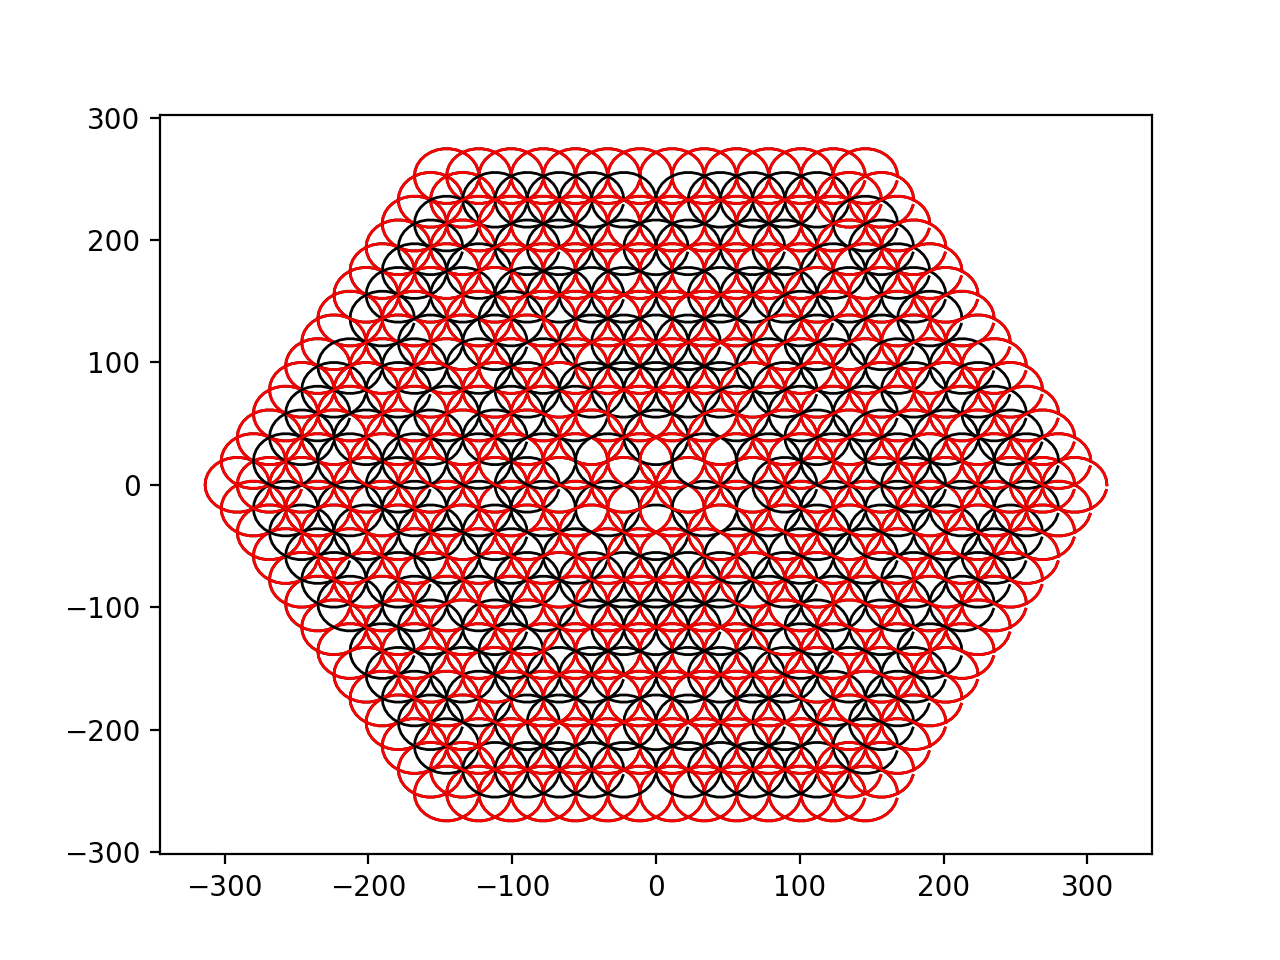

In [4]:
robot.plot()

Then we want a hex pattern with horizontal spacing in rows of $3r$ and spacing between rows of $(\sqrt{3}/2) r$. The offset between the centers in neighboring rows is $3r/2$.

In [5]:
# Just a tool to make a hex tiling
def hex_plot(r=313., nrows=3, ncols=3):
    for icol in np.arange(ncols):
        for irow in np.arange(nrows):
            xoff = (irow % 2) * 1.5 * r
            xcen = xoff + (np.float32(icol) - (np.float32(ncols) / 2)) * 3. * r
            ycen = np.float32(irow) * np.sqrt(3.) * r / 2.
            robot.plot(xoff=xcen, yoff=ycen)

<IPython.core.display.Javascript object>


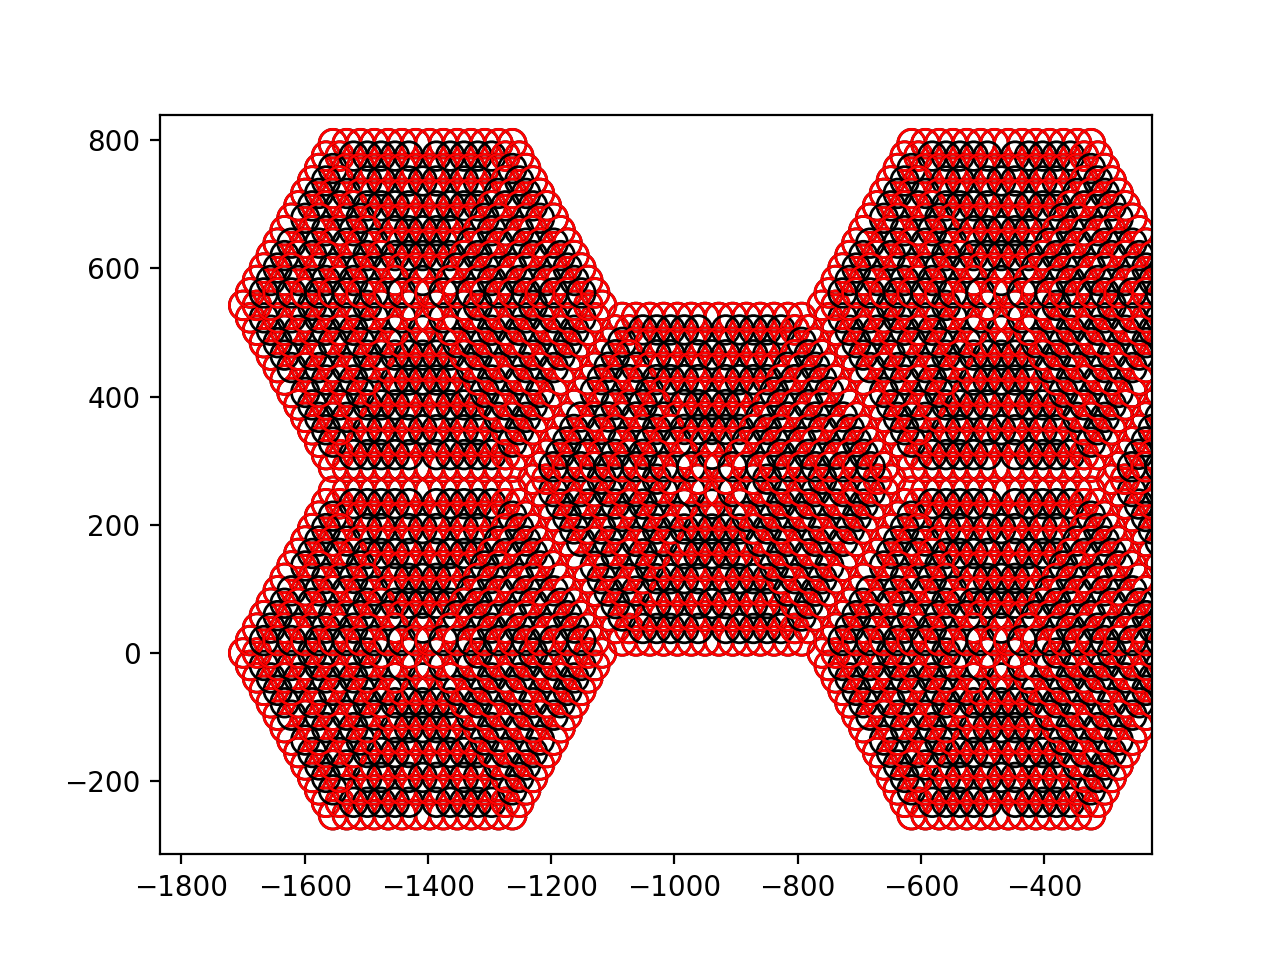

In [6]:
hex_plot()

In [7]:
robot = observesim.robot.Robot(fps_layout='central_park')

For central park configuration, the right spacing is probably about 315 to 325 mm if we want to leave holes. Or about half that if we want to fill in the Central Park area.

<IPython.core.display.Javascript object>


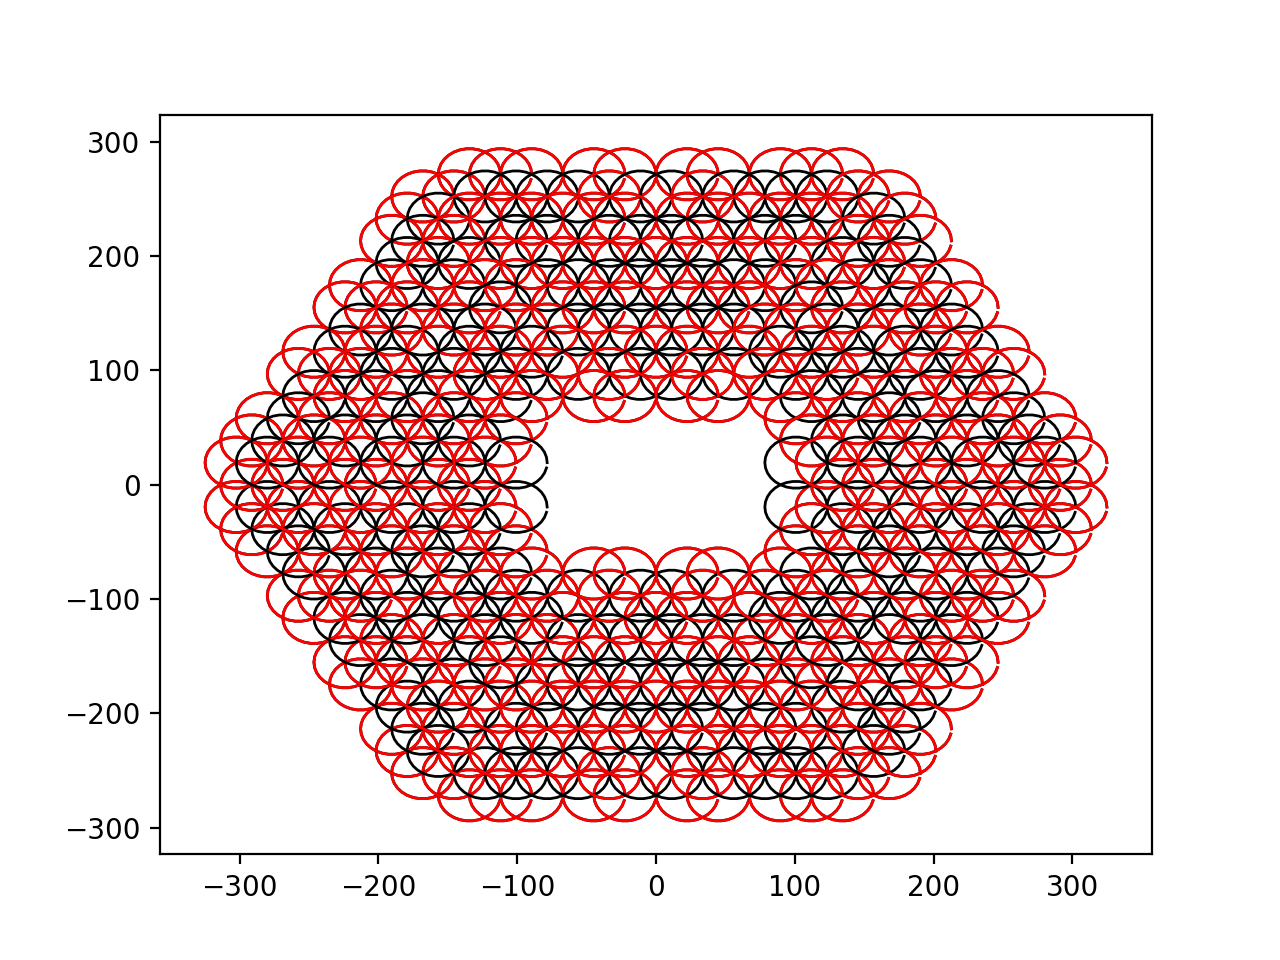

In [8]:
robot.plot()

<IPython.core.display.Javascript object>


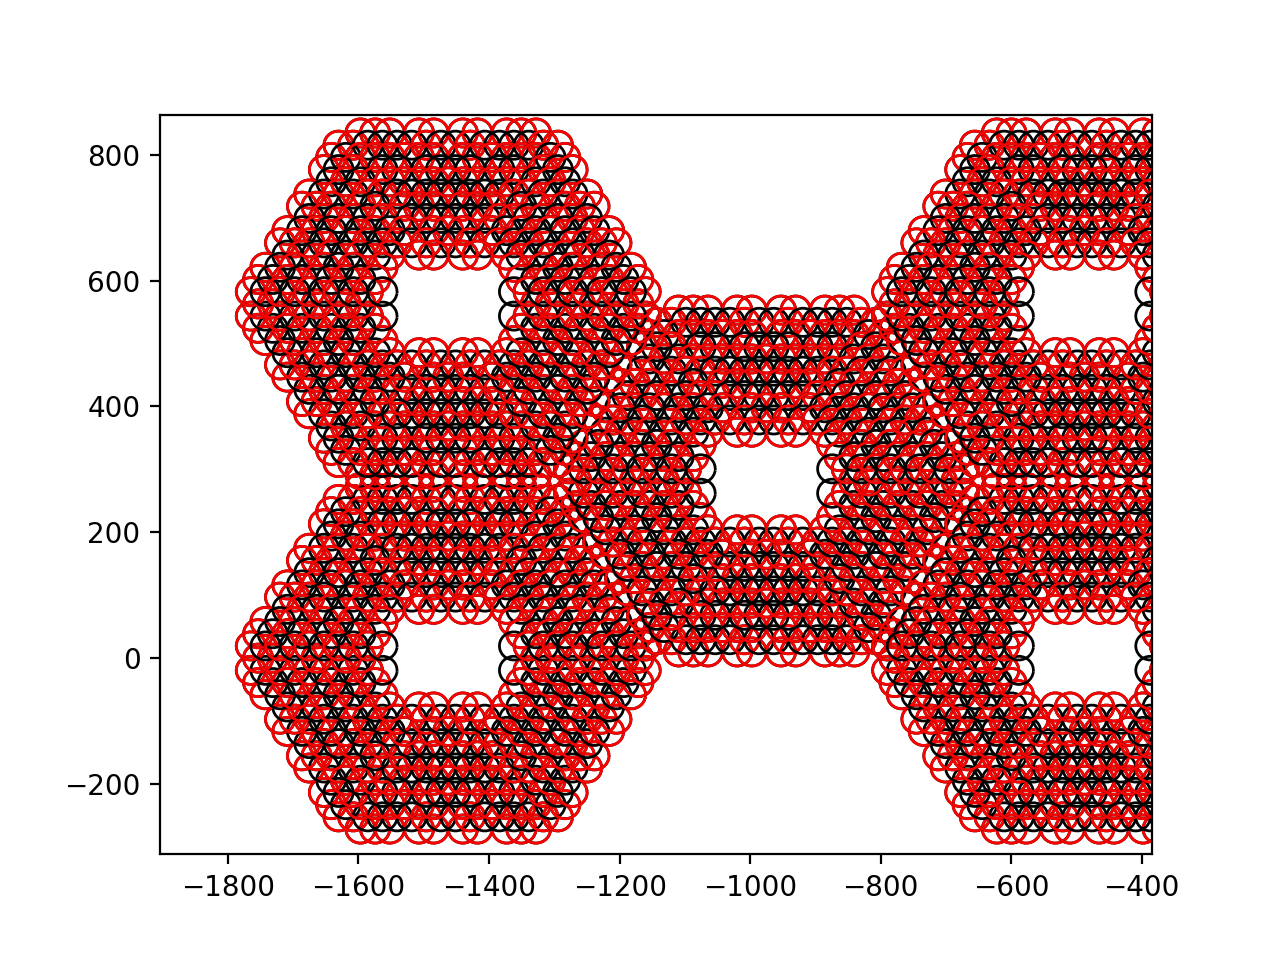

In [9]:
hex_plot(r=325.)

<IPython.core.display.Javascript object>


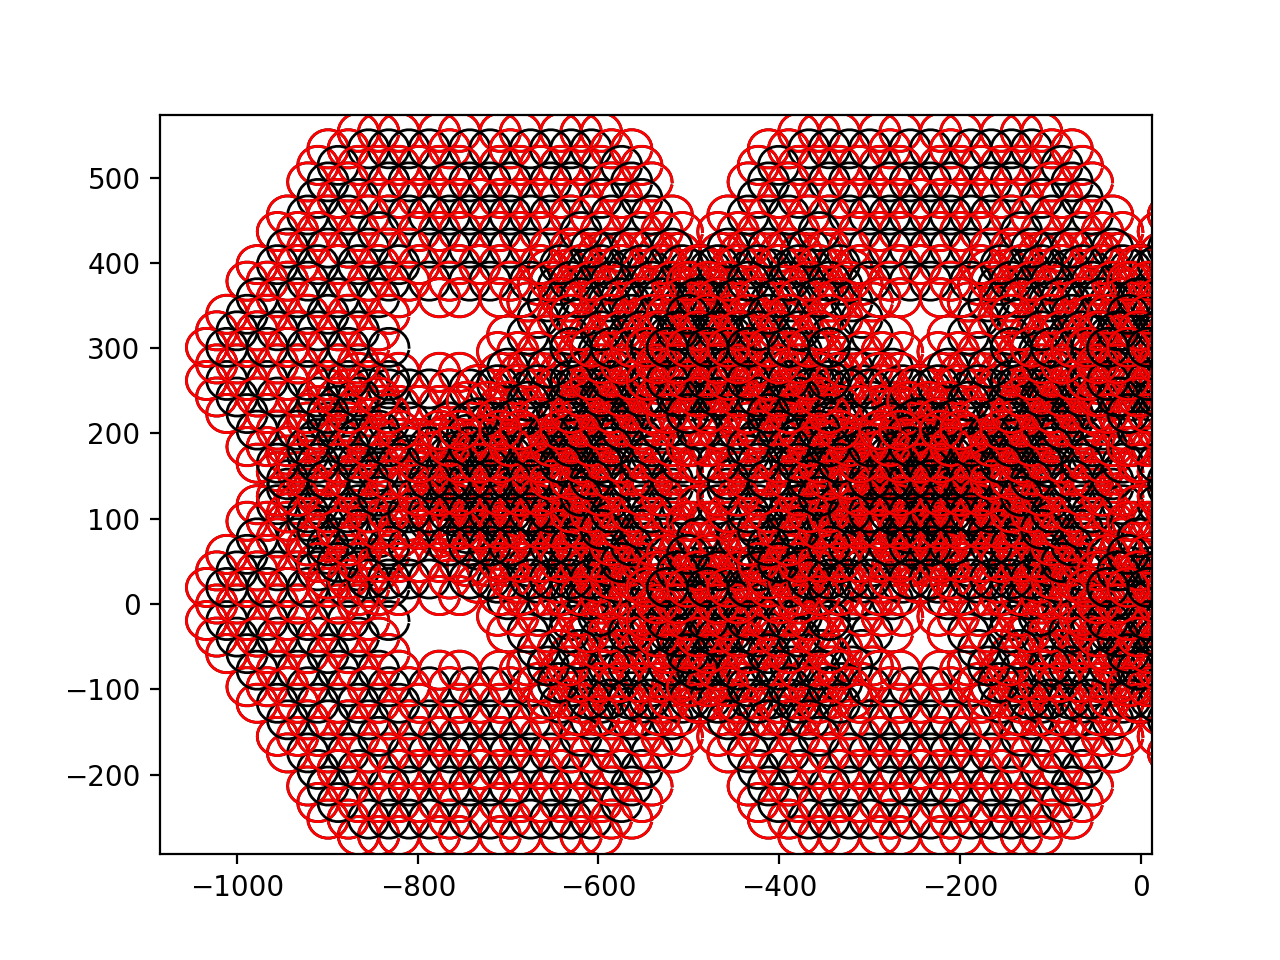

In [10]:
hex_plot(r=325. * 0.5)

We need to review what these mean in degrees. Using the distance in mm to 1 deg off-axis, we find:

 * 331.4 mm at LCO
 * 218.6 mm at APO
 
We will use these as the plate scale relevant for placing fields.

This means that:

 * $r = 0.94$ deg at LCO and $r=1.43$ deg at APO for the filled hex case
 * $r = 0.98$ deg at LCO and $r=1.49$ deg at APO for the Central Park sparse case (half that to fill the center).

The area per field is $3 \sqrt{3} / 2 r^2$. So if we are going to connect this to a Sloane tiling, we need one with $N = [4 \pi (180^\circ / \pi)^2] / [3\sqrt{3} / 2 r^2]$ points.

In [11]:
# For LCO
r = 0.94
print((3 * np.sqrt(3) / 2. * r**2))
print(4. * np.pi * (180. / np.pi)**2 / (3 * np.sqrt(3) / 2. * r**2))

2.29566014035
17969.9775783


In [12]:
# For APO
r = 1.43
print((3 * np.sqrt(3) / 2. * r**2))
print(4. * np.pi * (180. / np.pi)**2 / (3 * np.sqrt(3) / 2. * r**2))

5.3128060446
7764.81597543


There is a 7682-point covering, and a 18752-point covering. These will do for the moment. 

I'll note as an aside that we might want to create our own uniform tilings at some point, using healpix to define a near-Cartesian map on which to define a hex pattern.

In [13]:
fields_north = sloane.Sloane(n=7682)
fields_south = sloane.Sloane(n=18752)
fields_north.deccut(nsdiv)
fields_south.deccut(nsdiv, above=False)

7682
18752


In [14]:
def set_moll():
    m = basemap.Basemap(projection='moll', lon_0=270, resolution='c')

    # draw parallels and meridians.
    m.drawparallels(np.arange(-90., 120., 30.),
                    linewidth=0.5,
                    labels=[1, 0, 0, 0],
                    labelstyle='+/-')
    m.drawmeridians(np.arange(0., 420., 60.), linewidth=0.5)
    m.drawmapboundary()
    return(m)

def convert_radec(m, ra, dec):
    return m(((360. - ra) + 180.) % 360., dec, inverse=False)


<IPython.core.display.Javascript object>


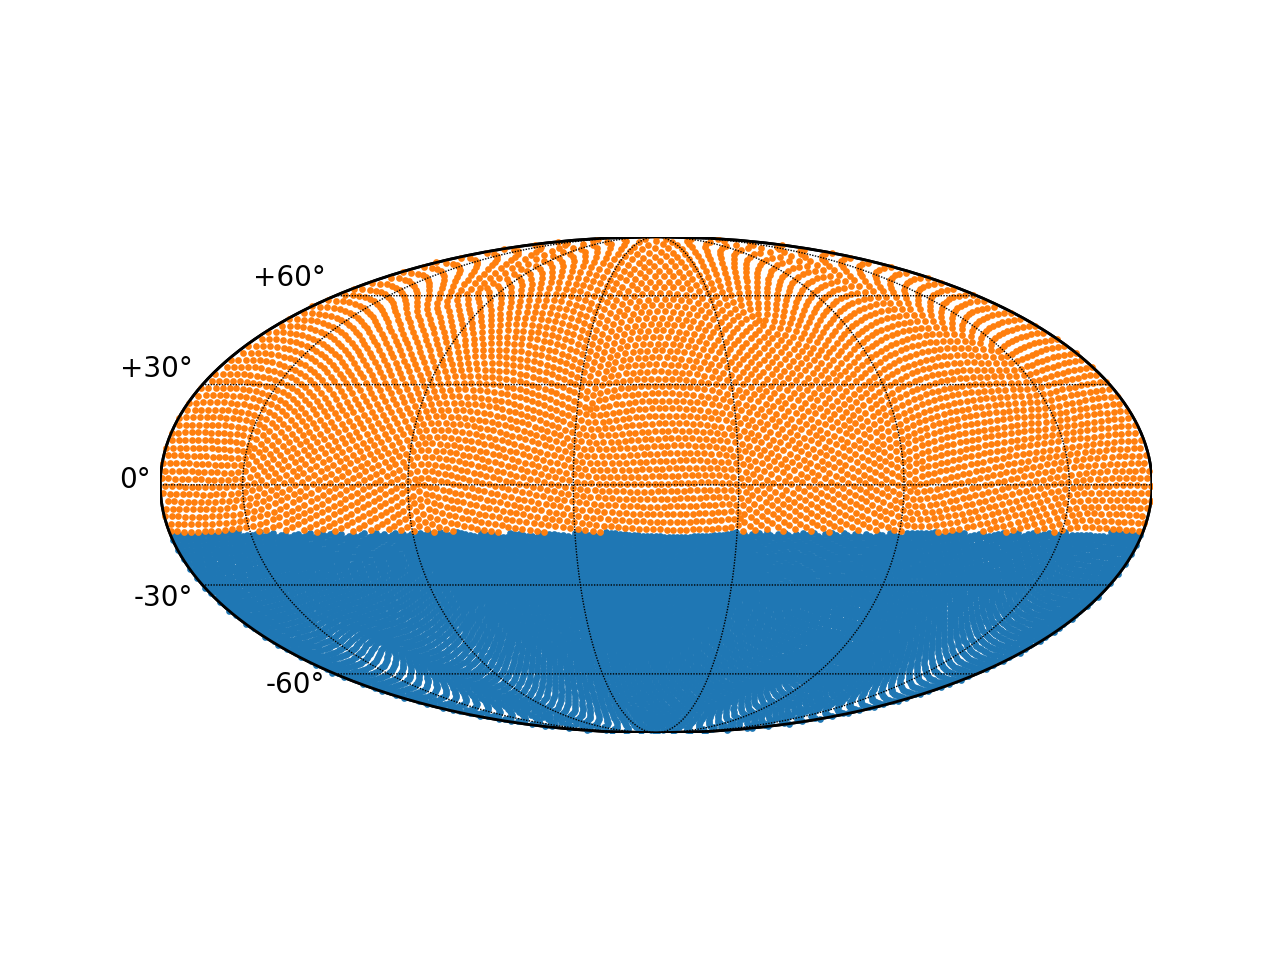

In [16]:
m = set_moll()
(x, y) = convert_radec(m, fields_south.ra, fields_south.dec)
sc = plt.scatter(x, y, s=2)
(x, y) = convert_radec(m, fields_north.ra, fields_north.dec)
sc = plt.scatter(x, y, s=2)

## How to specify cadence

We need to specify cadence in some way. What I describe here just describes the number of epochs, and the exposures for each epoch. Any more detailed constraints on cadence need a more complex description.

We specify an ndarray, with the following tags:

 * nepochs : number of epochs
 * nexp[400] : number exposures at each epoch
 * lunation[400] : maximum lunation at each epoch

In [17]:
field_dtype = np.dtype([('label', np.object),
                        ('ra', np.float64),
                          ('dec', np.float64),
                          ('nepochs', np.int32),
                          ('nexp', np.int32, 400),
                          ('lunation', np.float32, 400)])

## Defining the regions

In order to assign a cadence to each field, we use the following rules. This is what make_fields() does below.

* At minimum all fields need enough epochs to get all MWM "Disco" targets
* Also at minimum all fields need three dark epochs for WDs.
* TESS stars, which are everywhere, need at least one epoch with some minimum number of exposures. Here we assign this to a fourth epoch which can be bright. 
* Fields which have a special BHM status go as follows 
  * if in BHM MED: 4 exposures 12 dark epochs, else
  * if in BHM WIDE A: 4 exposures 3 dark epochs, else
  * if in BHM WIDE B: 4 exposures 2 dark epochs, else
  * if in BHM SPIDERS: 1 exposure 4 dark epochs, else
* BHM RM: 8 exposures 174 dark epochs
* MWM RV: M exposures N dark epochs, designated per field

HOWEVER: I did not find a specification of the RM fields.

We need to grab some information from my target assessment notebook to implement this.

In [19]:
nside = 32

# Some healpix maps
npe = fitsio.read('programs-npe.fits') # this will tell you if targets are in some region
nt = fitsio.read('programs-nt.fits') # this will tell you how many in each healpix
tden = np.float32(nt) / healpy.nside2pixarea(nside, degrees=True)

# This tells you how the programs are indexed in the above arrays
programs = ['Disco', 'Dust', 'ATLaS_RV', 'ATLaS_TESS',
            'WD', 'SOE_OPT', 'SOE_IR', 'SPIDERS_AGN',
            'ReSpeQ_WIDEA', 'ReSpeQ_WIDEB', 'ReSpeQ_MED',
            'ReSpeQ_RM']
itess = 3
ibhm_med = 10
ibhm_wideb = 9
ibhm_widea = 8
ibhm_spiders = 7

In [20]:
napogee = 250

# This code will make the fields for the wide-field
def make_fields(ra, dec, area=5.3):
    fields = np.zeros(len(ra), dtype=field_dtype)
    label = np.zeros(len(ra), dtype=np.dtype('a20'))
    label[:] = 'allsky'
    fields['label'] = label
    fields['ra'] = ra
    fields['dec'] = dec
    
    hpix = healpy.ang2pix(nside, ra, dec, lonlat=True)
    nexp_tess = npe[hpix, itess]
    bhm_med = npe[hpix, ibhm_med] > 0
    bhm_widea = npe[hpix, ibhm_widea] > 0
    bhm_wideb = npe[hpix, ibhm_wideb] > 0
    bhm_spiders = npe[hpix, ibhm_spiders] > 0
    density_disco = tden[hpix, 0]
    
    # Express cadences as big array. Initialize number of 
    # epochs to the number necessary to cover DISCO
    disco_epochs = np.int32(np.ceil(density_disco * area / napogee))
    field_nepochs = disco_epochs
    field_nexp = np.zeros((len(field_nepochs), 400), dtype=np.int32)
    for ifield in np.arange(len(field_nepochs)):
        field_nexp[ifield, 0:field_nepochs[ifield]] = 1
    field_lunation = np.ones((len(field_nepochs), 400))
    
    # But minimum number of epochs according to WD + TESS
    ilow = np.where(field_nepochs < 4)[0]
    field_nepochs[ilow] = 4
    
    # WDs require three epochs dark time.
    field_lunation[:, 0:3] = 0.35
    field_nexp[:, 0:3] = 1
    
    # TESS appears to require a number of its exposures
    # at one epoch. We assign this to the first bright 
    # exposure in the list. We assume the field has three
    # dark exposures we don't need to retake
    field_nexp[:, 4] = (nexp_tess - 3) 
    ilow = np.where((field_nexp[:, 4] < 0))
    field_nexp[ilow, 4] = 1

    # Now lets set things for things in SPIDERS
    ispiders = np.where(bhm_spiders & ~bhm_med & ~bhm_widea & ~ bhm_wideb)[0]
    label = np.zeros(len(ispiders), dtype=np.dtype('a20'))
    label[:] = 'spiders'
    fields['label'][ispiders] = label
    field_nexp[ispiders, 0] = (nexp_tess[ispiders] - 4)
    field_nexp[ispiders, 1] = 4
    
    # Now lets set things for things in SPIDERS
    iwideb = np.where(bhm_wideb & ~bhm_widea & ~ bhm_med)[0]
    label = np.zeros(len(iwideb), dtype=np.dtype('a20'))
    label[:] = 'wideb'
    fields['label'][iwideb] = label
    field_nexp[iwideb, 0] = 4
    field_nexp[iwideb, 1] = 4
    
    # Now lets set things for things in SPIDERS
    iwidea = np.where(bhm_widea & ~ bhm_med)[0]
    label = np.zeros(len(iwidea), dtype=np.dtype('a20'))
    label[:] = 'widea'
    fields['label'][iwidea] = label
    field_nexp[iwideb, 0] = 4
    field_nexp[iwidea, 0] = 4
    field_nexp[iwidea, 1] = 4
    field_nexp[iwidea, 2] = 4
    
    # Now lets set things for things in SPIDERS
    imed = np.where(bhm_med)[0]
    label = np.zeros(len(imed), dtype=np.dtype('a20'))
    label[:] = 'med'
    fields['label'][imed] = label
    ilow = np.where(bhm_med & (field_nepochs < 12))[0]
    field_nepochs[ilow] = 12
    field_nexp[imed, 0:12] = 4
    
    fields['nepochs'] = field_nepochs
    fields['nexp'] = field_nexp
    fields['lunation'] = field_lunation
    
    return fields

In [21]:
# This code makes the ATLAS RV fields
rv = ascii.read('atlasFields2.csv')
ikeep = np.where(rv['Dec Deg'] > nsdiv)[0]
north_rv = np.zeros(len(ikeep), dtype=field_dtype)
label = np.zeros(len(ikeep), dtype=np.dtype('a20'))
label[:] = 'rv'
north_rv['label'] = label
north_rv['ra'] = np.array(rv['RA deg'][ikeep])
north_rv['dec'] = np.array(rv['Dec Deg'][ikeep])
north_rv['nepochs'] = np.array(rv['nVisits'][ikeep])
for i in np.arange(len(ikeep)):
    north_rv['nexp'][i][0:north_rv['nepochs'][i]] = np.array(rv['expLen'])[ikeep[i]]
    north_rv['lunation'][i][0:north_rv['nepochs'][i]] = 1.
ikeep = np.where(rv['Dec Deg'] < nsdiv)[0]
south_rv = np.zeros(len(ikeep), dtype=field_dtype)
label = np.zeros(len(ikeep), dtype=np.dtype('a20'))
label[:] = 'rv'
south_rv['label'] = label 
south_rv['ra'] = np.array(rv['RA deg'][ikeep])
south_rv['dec'] = np.array(rv['Dec Deg'][ikeep])
south_rv['nepochs'] = np.array(rv['nVisits'][ikeep])
for i in np.arange(len(ikeep)):
    south_rv['nexp'][i][0:south_rv['nepochs'][i]] = np.array(rv['expLen'])[ikeep[i]]
    south_rv['lunation'][i][0:south_rv['nepochs'][i]] = 1.

In [22]:
south = make_fields(fields_south.ra, fields_south.dec, area=2.3) # use area appropriate to LCO field spacing
south = np.append(south, south_rv)
north = make_fields(fields_north.ra, fields_north.dec, area=5.3) # use area appropriate to APO field spacing
north = np.append(north, north_rv)

<IPython.core.display.Javascript object>


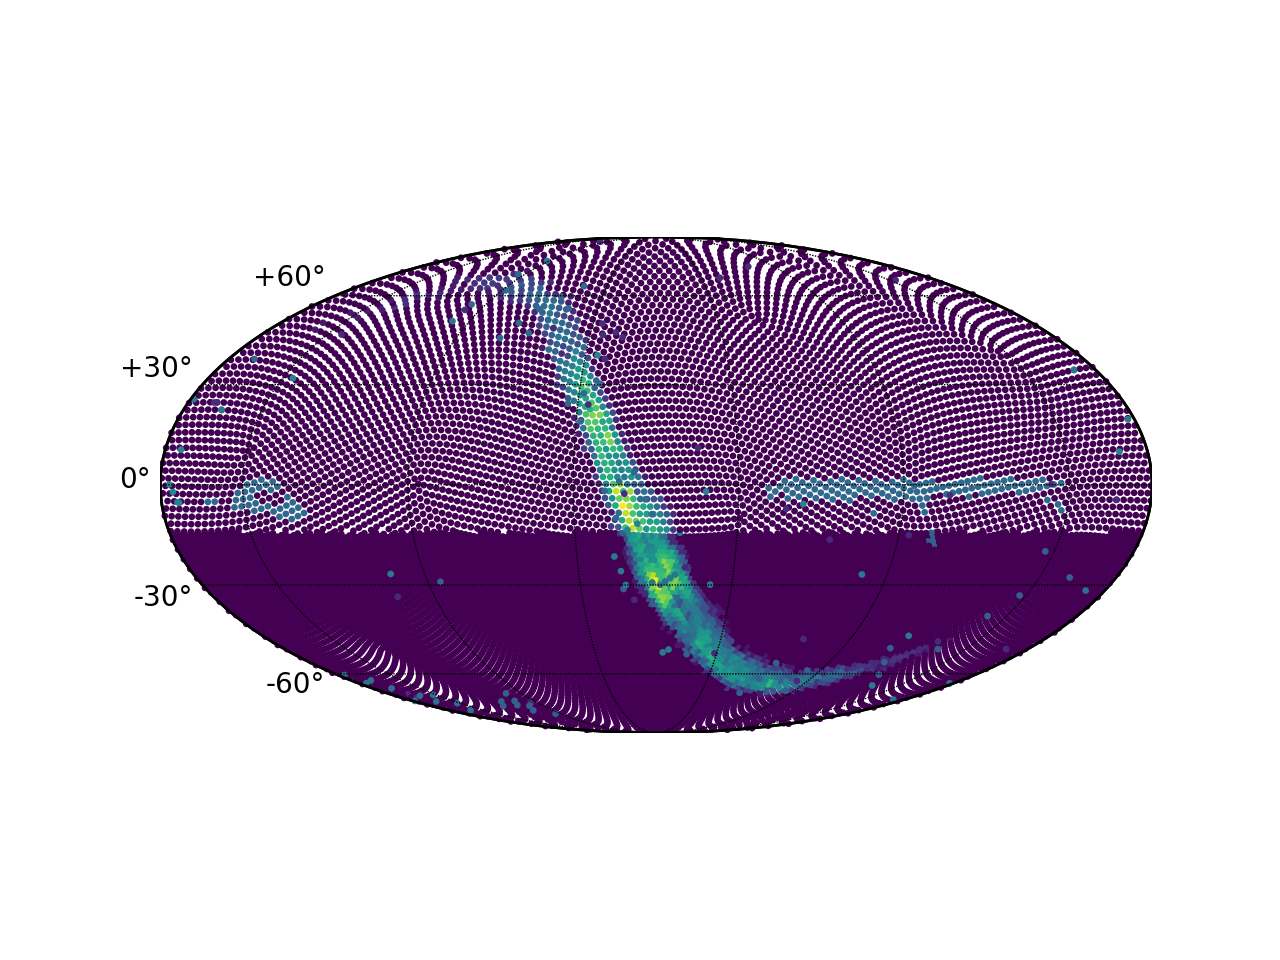

In [23]:
m = set_moll()
(x, y) = convert_radec(m, south['ra'], south['dec'])
sc = plt.scatter(x, y, c=np.log10(south['nepochs']), s=2)
(x, y) = convert_radec(m, north['ra'], north['dec'])
sc = plt.scatter(x, y, c=np.log10(north['nepochs']), s=2)

We write out the regions in the following fields.

In [24]:
fitsio.write('south-fields.fits', south, clobber=True)
fitsio.write('north-fields.fits', north, clobber=True)

## Some basic numbers

The regions here are defined as a good faith effort to understand what the targeting teams were trying to achieve. They are also the starting point for the simulations.

There are some basic numbers we can look at to evaluate the viability of this plan even without simulations. As we will see, it seems like some work needs to be done to craft a more viable plan. This is clear even without running a single simulation. Note that these numbers also do not include RM, for which I don't have locations.

First, let us establish what the total number of exposures can possibly be in the North and South. We use optimistic weather for each, assume 20 minutes per field including overhead, and 10 hours a night 330 nights a year, for five years.

In [25]:
nsouth = 330. * 10. * 5. * (60. / 20.) * 0.75
print("Number of LCO exposures possible: {nsouth:0.0f}".format(nsouth=nsouth))
nnorth = 330. * 10. * 5. * (60. / 20.) * 0.55
print("Number of APO exposures possible: {nnorth:0.0f}".format(nnorth=nnorth))

Number of LCO exposures possible: 37125
Number of APO exposures possible: 27225


Now let us look at the total number of exposures asked for:

In [26]:
south_ntotal = south['nexp'].sum() 
print("Number of LCO exposures desired: {south_ntotal}".format(south_ntotal=south_ntotal))
north_ntotal = north['nexp'].sum() 
print("Number of APO exposures desired: {north_ntotal}".format(north_ntotal=north_ntotal))

Number of LCO exposures desired: 75144
Number of APO exposures desired: 47410


It is useful to break that down further into dark and bright time:

In [27]:
south_ntotal = (south['nexp'] * (south['lunation'] < 0.5)).sum() 
print("Number of LCO dark exposures desired: {south_ntotal}".format(south_ntotal=south_ntotal))
north_ntotal = (north['nexp'] * (north['lunation'] < 0.5)).sum() 
print("Number of APO dark exposures desired: {north_ntotal}".format(north_ntotal=north_ntotal))

Number of LCO dark exposures desired: 39349
Number of APO dark exposures desired: 22204


In [28]:
south_ntotal = (south['nexp'] * (south['lunation'] > 0.5)).sum() 
print("Number of LCO bright exposures desired: {south_ntotal}".format(south_ntotal=south_ntotal))
north_ntotal = (north['nexp'] * (north['lunation'] > 0.5)).sum() 
print("Number of APO bright exposures desired: {north_ntotal}".format(north_ntotal=north_ntotal))

Number of LCO bright exposures desired: 35795
Number of APO bright exposures desired: 25206


We can further break that into the different types:

In [29]:
labels = np.unique(south['label'])
for label in labels:
    ilabel = np.where(south['label'] == label)[0]
    ntotal = south['nexp'][ilabel].sum() 
    print("Number of LCO exposures for {label}: {ntotal}".format(label=label.decode(), ntotal=ntotal))

Number of LCO exposures for allsky: 24011
Number of LCO exposures for med: 288
Number of LCO exposures for rv: 3266
Number of LCO exposures for spiders: 47579


In [30]:
labels = np.unique(north['label'])
for label in labels:
    ilabel = np.where(north['label'] == label)[0]
    ntotal = north['nexp'][ilabel].sum() 
    print("Number of APO exposures for {label}: {ntotal}".format(label=label.decode(), ntotal=ntotal))

Number of APO exposures for allsky: 24894
Number of APO exposures for med: 7008
Number of APO exposures for rv: 1801
Number of APO exposures for spiders: 5302
Number of APO exposures for widea: 4202
Number of APO exposures for wideb: 4203


Finally, it is useful to break up into RA in hours. This exercise suggests that the LST distribution is not great. It can been smoothed out a little by observing not-at-transit, but there is still some balancing to do.

In [31]:
south_lst = np.zeros(24)
for field in south:
    nexp = field['nexp'].sum()
    ilst = np.int32(np.floor(field['ra'] / 15.))
    south_lst[ilst] = south_lst[ilst] + nexp

In [32]:
north_lst = np.zeros(24)
for field in north:
    nexp = field['nexp'].sum()
    ilst = np.int32(np.floor(field['ra'] / 15.))
    north_lst[ilst] = north_lst[ilst] + nexp

<IPython.core.display.Javascript object>


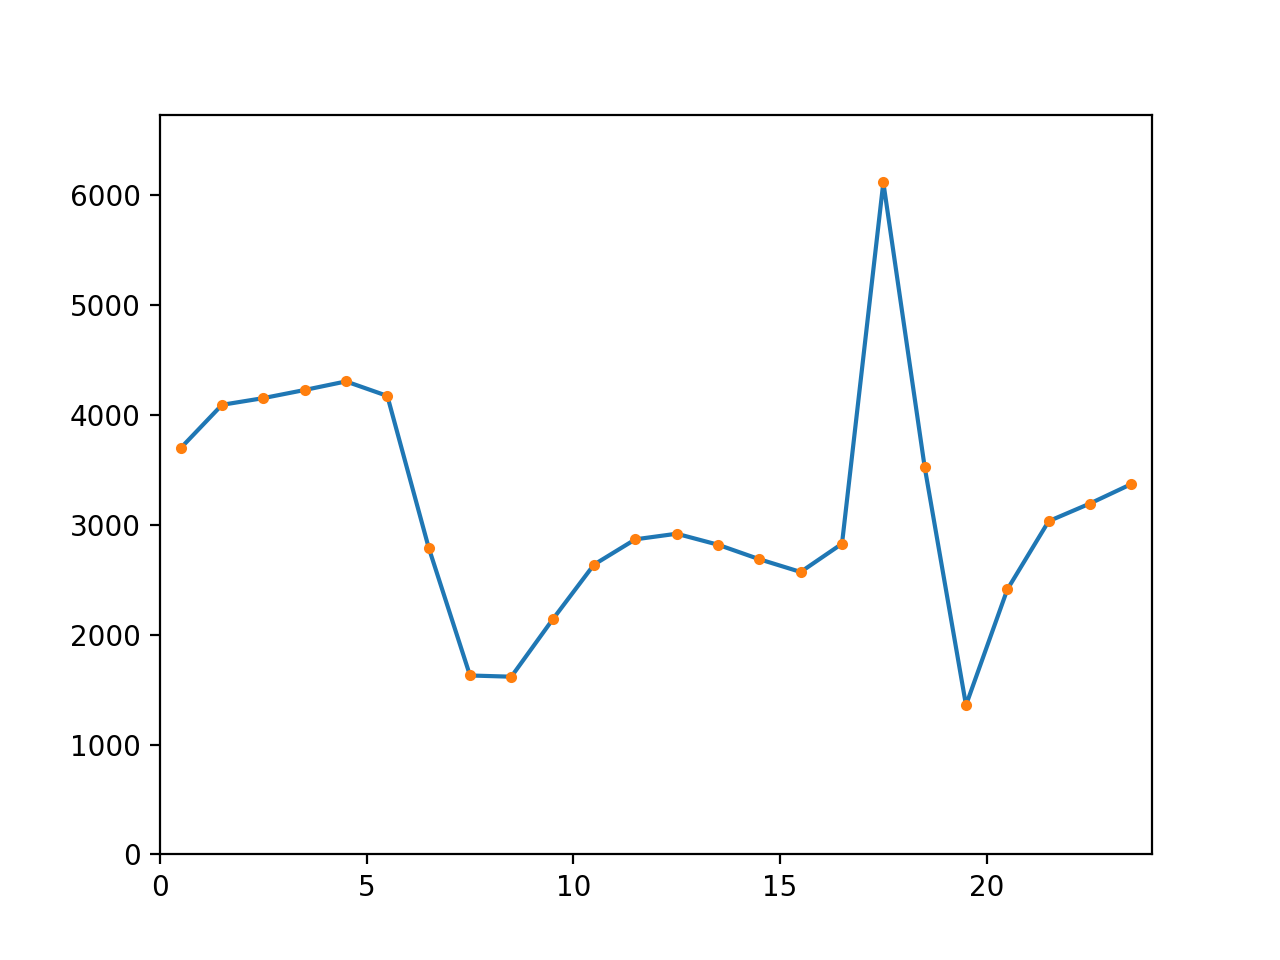

(0.0, 6726.5000000000009)

In [33]:
plt.plot(np.arange(24) + 0.5, south_lst)
plt.plot(np.arange(24) + 0.5, south_lst, '.')
plt.xlim((0., 24.))
plt.ylim((0., south_lst.max() * 1.1))

<IPython.core.display.Javascript object>


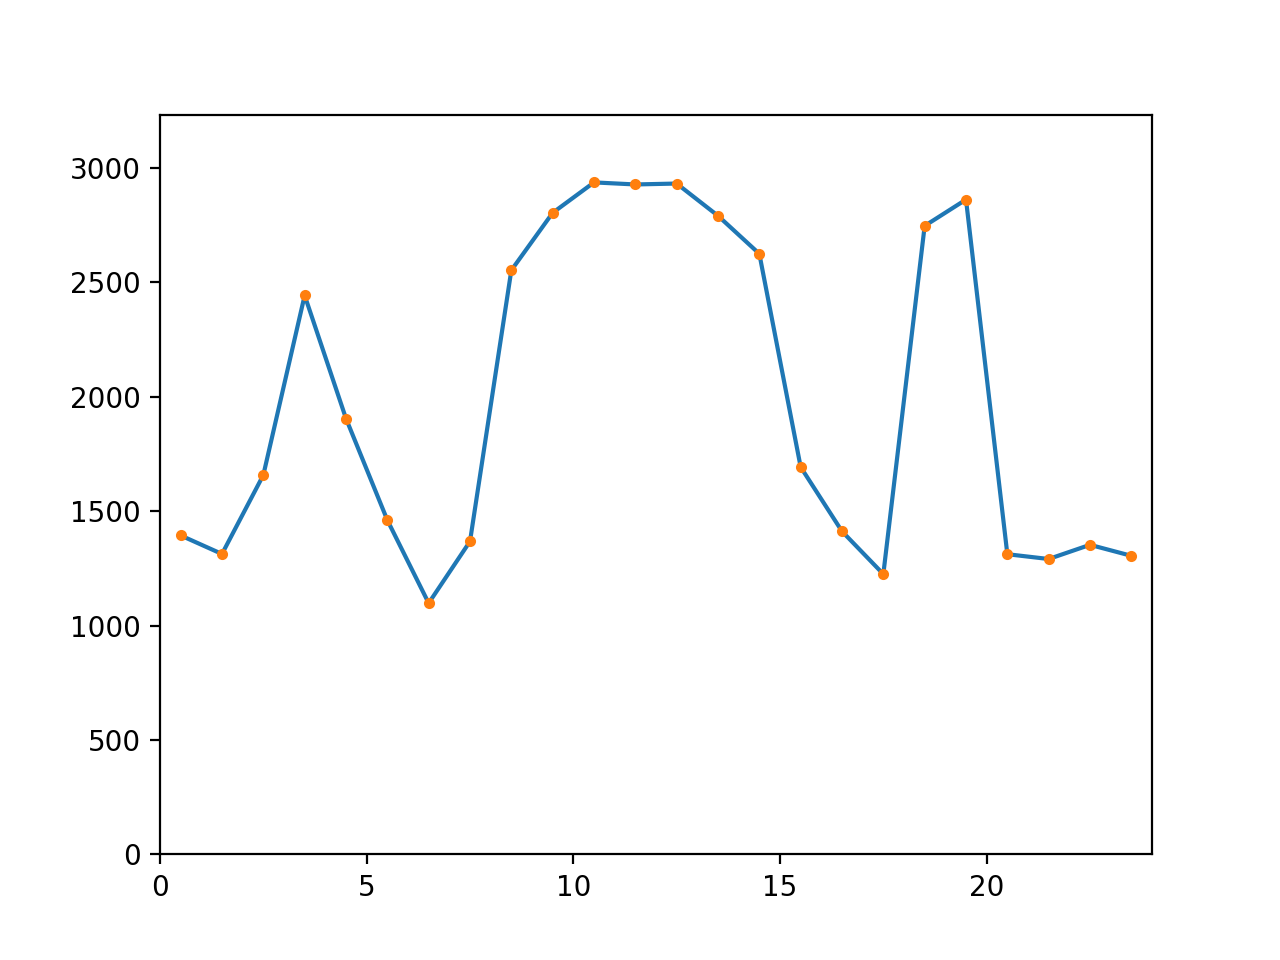

(0.0, 3230.7000000000003)

In [34]:
plt.plot(np.arange(24) + 0.5, north_lst)
plt.plot(np.arange(24) + 0.5, north_lst, '.')
plt.xlim((0., 24.))
plt.ylim((0., north_lst.max() * 1.1))